# 时间段和周期的数据分布

In [1]:
import pandas as pd
import numpy as np
from scipy import linalg
import sys
sys.path.append("/Users/coffee/Documents/code/QkidsAutomation")
import os
import datetime
from qkids import Week
# from qkids.DatabasePool import get_schedule_connection
from schedule.GBDT import prepare_data
import matplotlib.pyplot as plt
from qkids.DatabasePool import get_odps
odps = get_odps()

In [3]:
week = Week()
historical_data = prepare_data()
historical_data['year'] = historical_data.begin.apply(lambda x: x.year)
historical_data['time_index'] = historical_data.time.apply(lambda x: week.day_times.index(x))
def split_by_spell(x):
    if x.time() < datetime.time(12,0):
        return 0
    elif x.time() >  datetime.time(17,0):
        return 2
    else:
        return 1
historical_data['spell'] = historical_data.begin.apply(split_by_spell)
historical_data['yearweek'] = historical_data.begin.apply(lambda x : x.strftime("%Y%W"))
historical_data['time_index_week'] = historical_data.time_index + (historical_data.dayofweek *  17)

In [58]:
# 聚合到每天时间段
historical_data_cnt= historical_data[['date', 'cnt', 'spell']].groupby(['date','spell']).sum()
historical_data_cnt = historical_data_cnt.unstack(level=1)
historical_data_cnt.columns = ['morning', 'afternoon', 'evening']

In [4]:
# get odps data
students = odps.get_table('dwd_students').to_df()
students = students[students.registed_at.notnull()]
students['date'] = students.registed_at.strftime("%Y-%m-%d")

In [164]:
students = students[students.first_paid_at.notnull()]

In [163]:
students.head(10)

TransientProgressBar(value=0.0)

InstancesProgress()

HTMLNotifier()

DFViewWidget()

,user_id,registed_at,first_large_buy_at,first_small_buy_at,place,source_flag,referee_id,vip,created_at,updated_at,source_cata,province,city,birthday,level,first_product_id,min_large_product_id,first_paid_at,date
0,1,2015-11-18 18:21:04,NaT,NaT,新疆 伊犁,None,0,0,2015-11-18 18:21:04,2020-02-15 17:39:01,0,新疆,伊犁,2006-01-01 00:00:00,7,NaN,NaN,NaT,2015-11-18
1,2,2015-11-18 18:21:04,NaT,NaT,新疆 伊犁,None,0,0,2015-11-18 18:21:04,2020-01-10 12:00:01,0,新疆,伊犁,1988-08-08 01:00:00,2,NaN,NaN,NaT,2015-11-18
2,6,2015-11-20 23:18:52,NaT,NaT,None,None,0,0,2015-11-20 23:18:52,2018-03-18 23:44:04,0,None,None,NaT,0,NaN,NaN,NaT,2015-11-20
3,7,2016-03-28 10:55:44,2016-11-09 18:37:01,2016-04-28 14:30:59,福建 厦门,tongledao,0,1,2015-11-30 22:15:19,2020-02-17 15:07:44,1,福建,厦门,2012-09-30 00:00:00,3,4.0,13.0,2016-04-28 14:30:59,2016-03-28
4,8,2016-04-22 19:12:53,2016-06-21 11:34:53,2016-01-08 18:33:34,福建 厦门,tongledao,0,1,2015-11-30 22:29:48,2020-02-17 20:44:23,1,福建,厦门,2016-06-13 00:00:00,-1,4.0,6.0,2016-01-08 18:33:34,2016-04-22
5,11,2015-12-02 10:43:29,NaT,NaT,None,None,9,0,2015-12-02 10:43:29,2019-07-24 14:14:22,2,None,None,2018-02-09 00:00:00,0,NaN,NaN,NaT,2015-12-02
6,12,2015-12-02 18:08:03,NaT,2016-07-04 17:29:56,福建 泉州,None,0,0,2015-12-02 18:08:03,2020-02-13 16:10:01,4,福建,泉州,2011-06-01 00:00:00,4,8.0,NaN,2016-07-04 17:29:56,2015-12-02
7,16,2015-12-07 18:40:03,NaT,NaT,福建 厦门,None,0,0,2015-12-07 18:40:03,2018-12-05 10:37:37,0,福建,厦门,2015-12-07 00:00:00,0,NaN,NaN,NaT,2015-12-07
8,17,2015-12-07 19:15:24,2018-02-01 10:25:33,2016-07-04 17:33:16,福建 厦门,None,0,1,2015-12-07 19:15:24,2020-02-07 08:30:02,4,福建,厦门,2013-01-01 00:00:00,1,8.0,5.0,2016-07-04 17:33:16,2015-12-07
9,18,2015-12-08 09:45:40,2016-11-11 09:04:22,2016-07-04 17:29:23,福建 厦门,None,0,1,2015-12-08 09:45:40,2020-02-17 15:59:13,4,福建,厦门,2007-01-01 00:00:00,1,8.0,13.0,2016-07-04 17:29:23,2015-12-08


In [165]:
# 处理odps数据到pandas
actual_student_cnt_by_date = students.groupby('date').agg(count=students.date.count()).to_pandas().set_index('date')['count']

TransientProgressBar(value=0.0)

InstancesProgress()

HTMLNotifier()

In [166]:
actual_student_cum_cnt_by_date = actual_student_cnt_by_date.cumsum().loc['2018-01-01':]
actual_student_cum_cnt_by_date.index = pd.to_datetime(actual_student_cum_cnt_by_date.index)

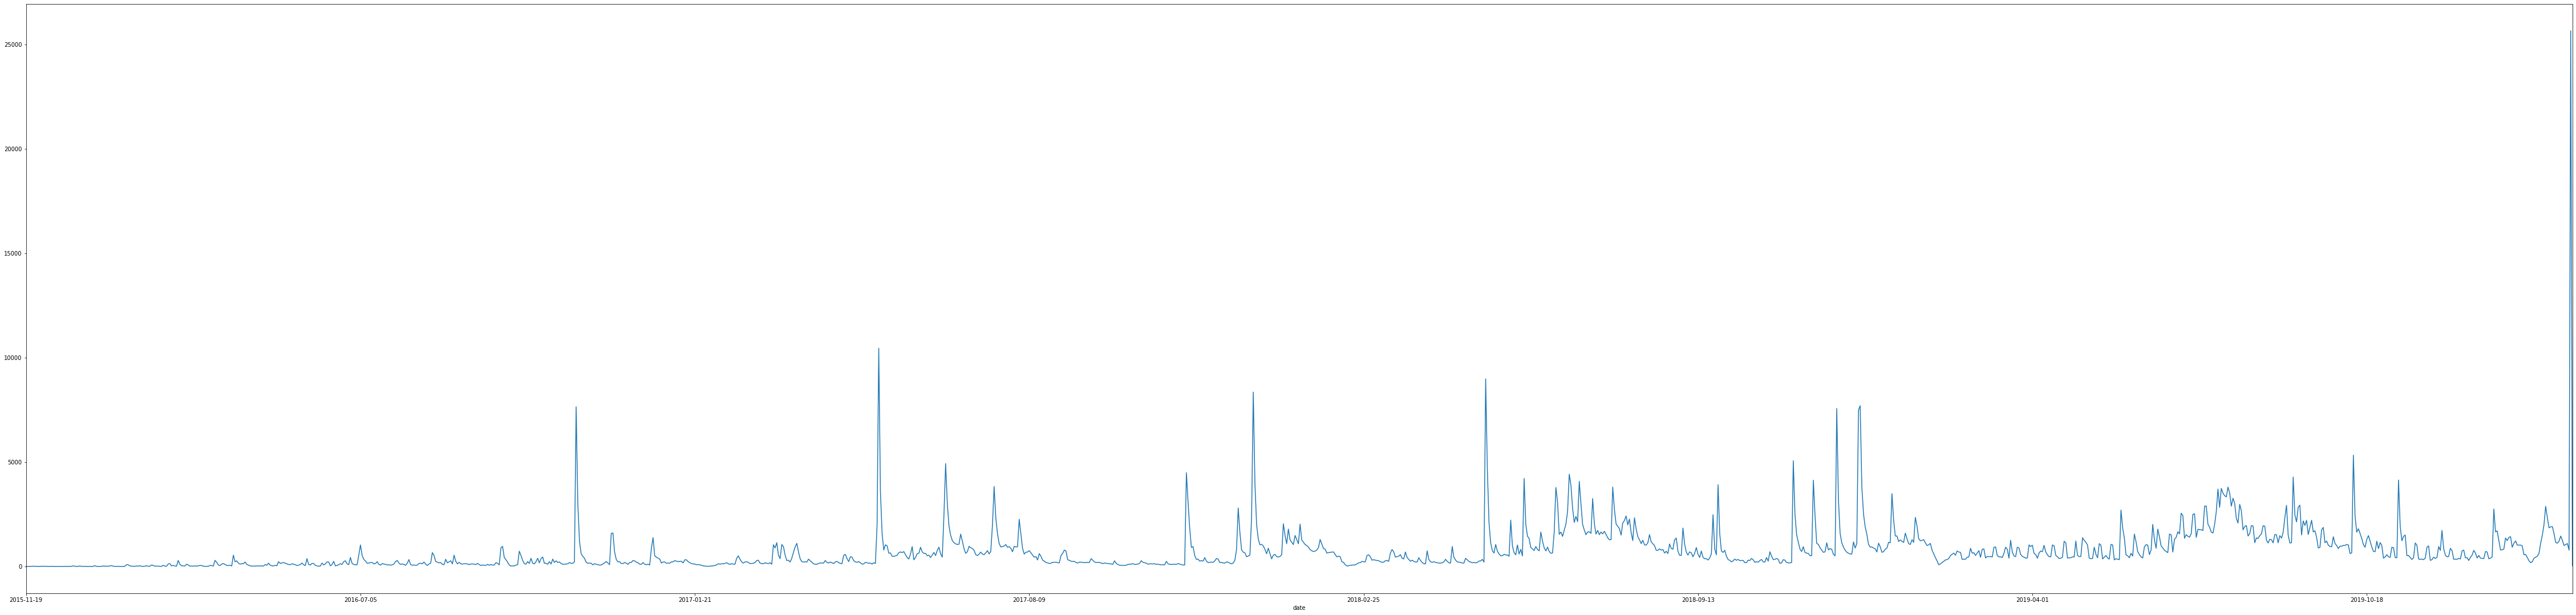

In [167]:
actual_student_cnt_by_date.plot(figsize=(80,19))

In [60]:
# 合并数据
historical_data_cnt['students'] = actual_student_cnt_by_date[historical_data_cnt.index]

In [61]:
historical_data_cnt

,morning,afternoon,evening,students
date,,,,
2018-01-01,NaN,NaN,5774.0,75259758
2018-01-02,NaN,NaN,6967.0,75578379
2018-01-03,NaN,NaN,5851.0,75897660
2018-01-04,NaN,NaN,5269.0,76217506
2018-01-05,NaN,NaN,5334.0,76537883
...,...,...,...,...
2020-02-12,23431.0,3568.0,28392.0,728151245
2020-02-13,23041.0,3310.0,27393.0,729747303
2020-02-14,23587.0,3387.0,26680.0,731345690


In [174]:
def ss(field, pre='norm'):
    a = historical_data_cnt[field]
    a = a.loc[~a.isna()]
    s = a / historical_data_cnt.loc[a.index, 'students']
    if pre == 'std':
        output = standardization(s)
    else:
        output = normalization(s)
    output.plot(figsize=(80,14))

def standardization(s):
    return (s - s.min()) / (s.max() - s.min())

def normalization(s):
    return (s - s.mean()) / s.std()

def midu(s):
    return s / s.sum()

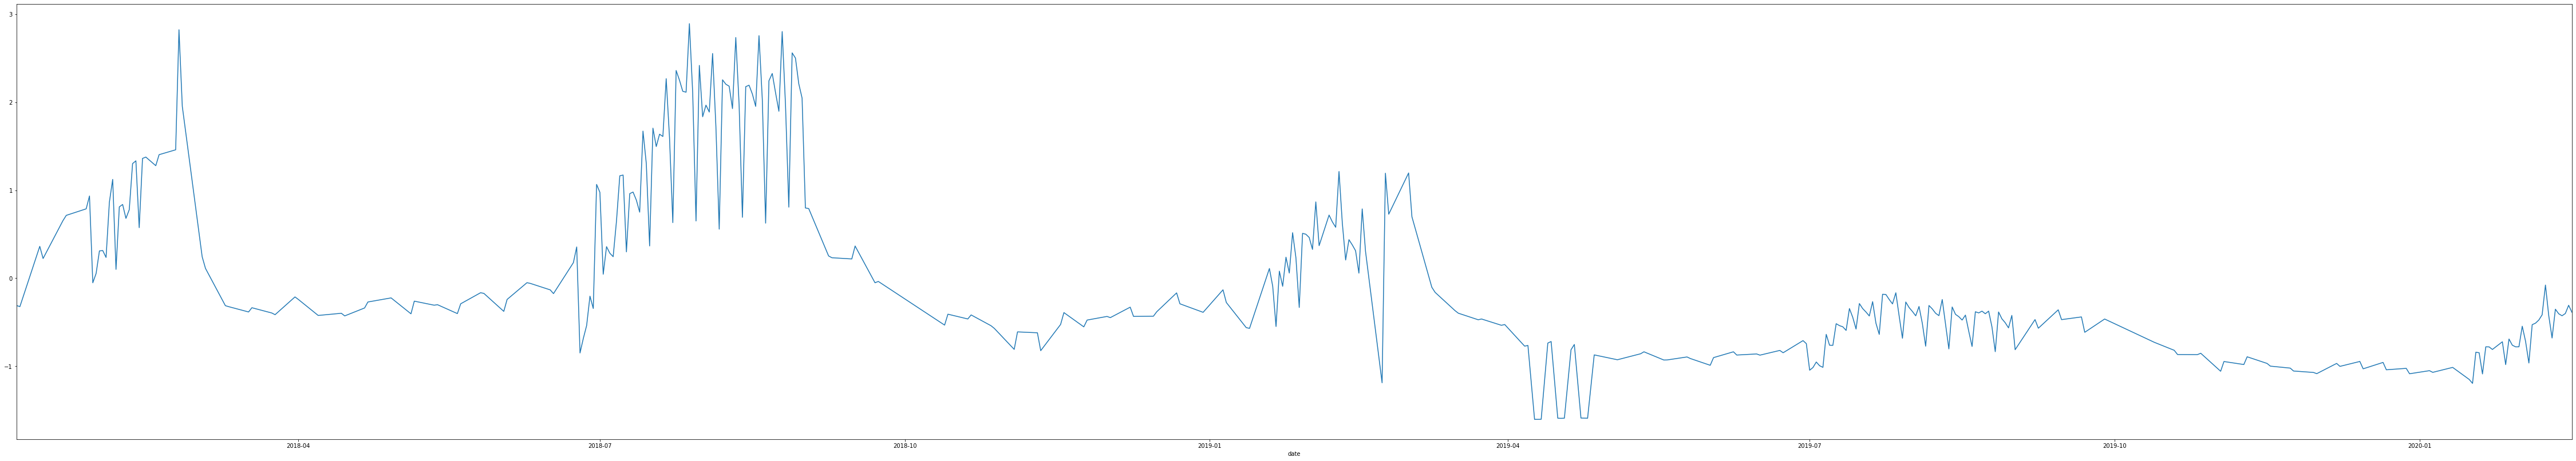

In [78]:
ss('morning')

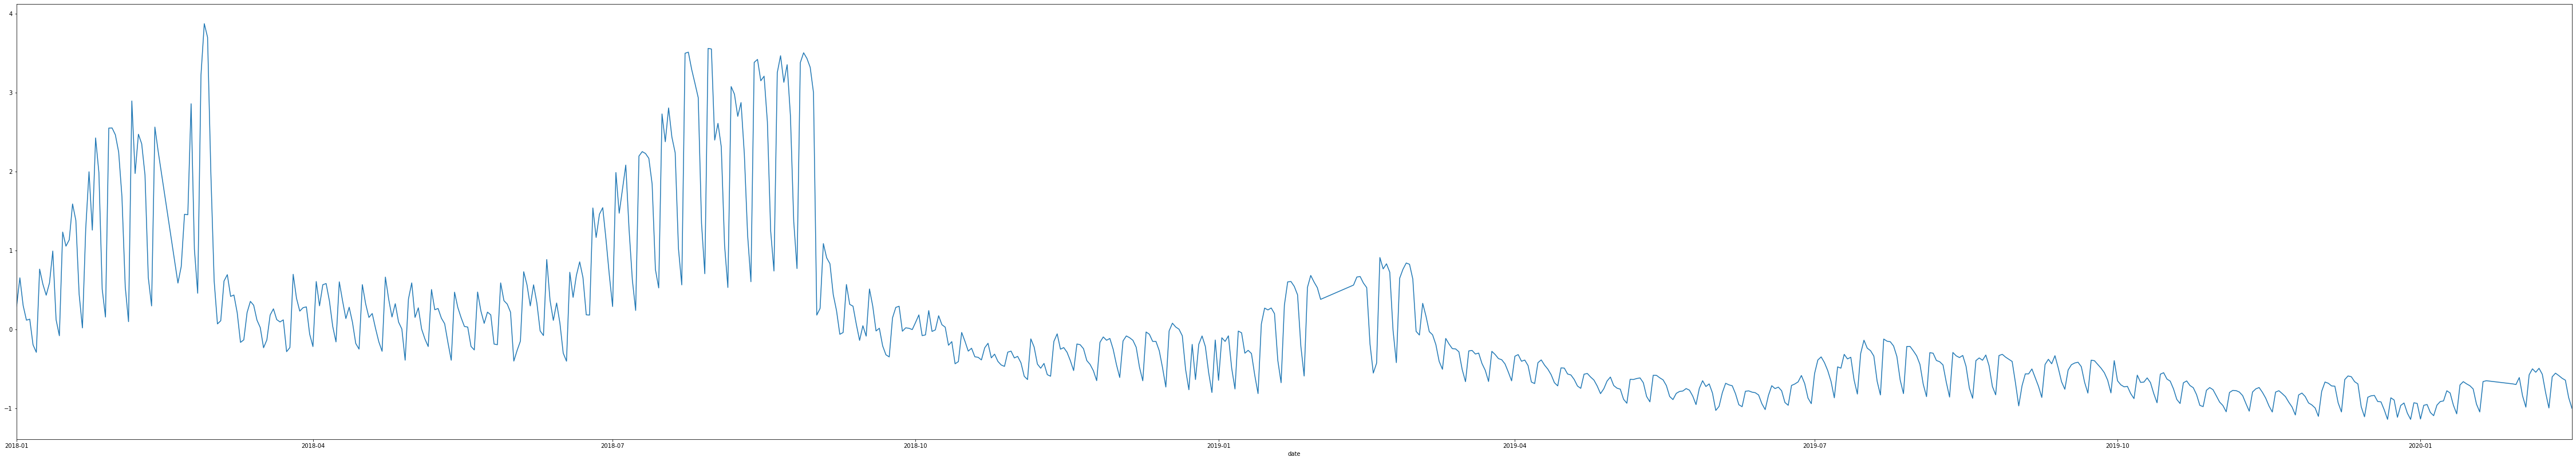

In [80]:
ss('evening')

In [154]:
# 查看没周的数据是否同分布
s = historical_data_cnt.evening / historical_data_cnt.students
s = s.loc[~s.isna()]
df = pd.DataFrame(s.values,  index = s.index, columns=['cnt'])
df['year']  = [ str(i.year) + i.strftime("%W") for i in df.index]
df['weekday']  = [ i.isoweekday() for i in df.index]

In [155]:
dfp = df.pivot(index='year', columns='weekday', values = 'cnt')

In [187]:
dfps = dfp.apply(midu, axis=1)

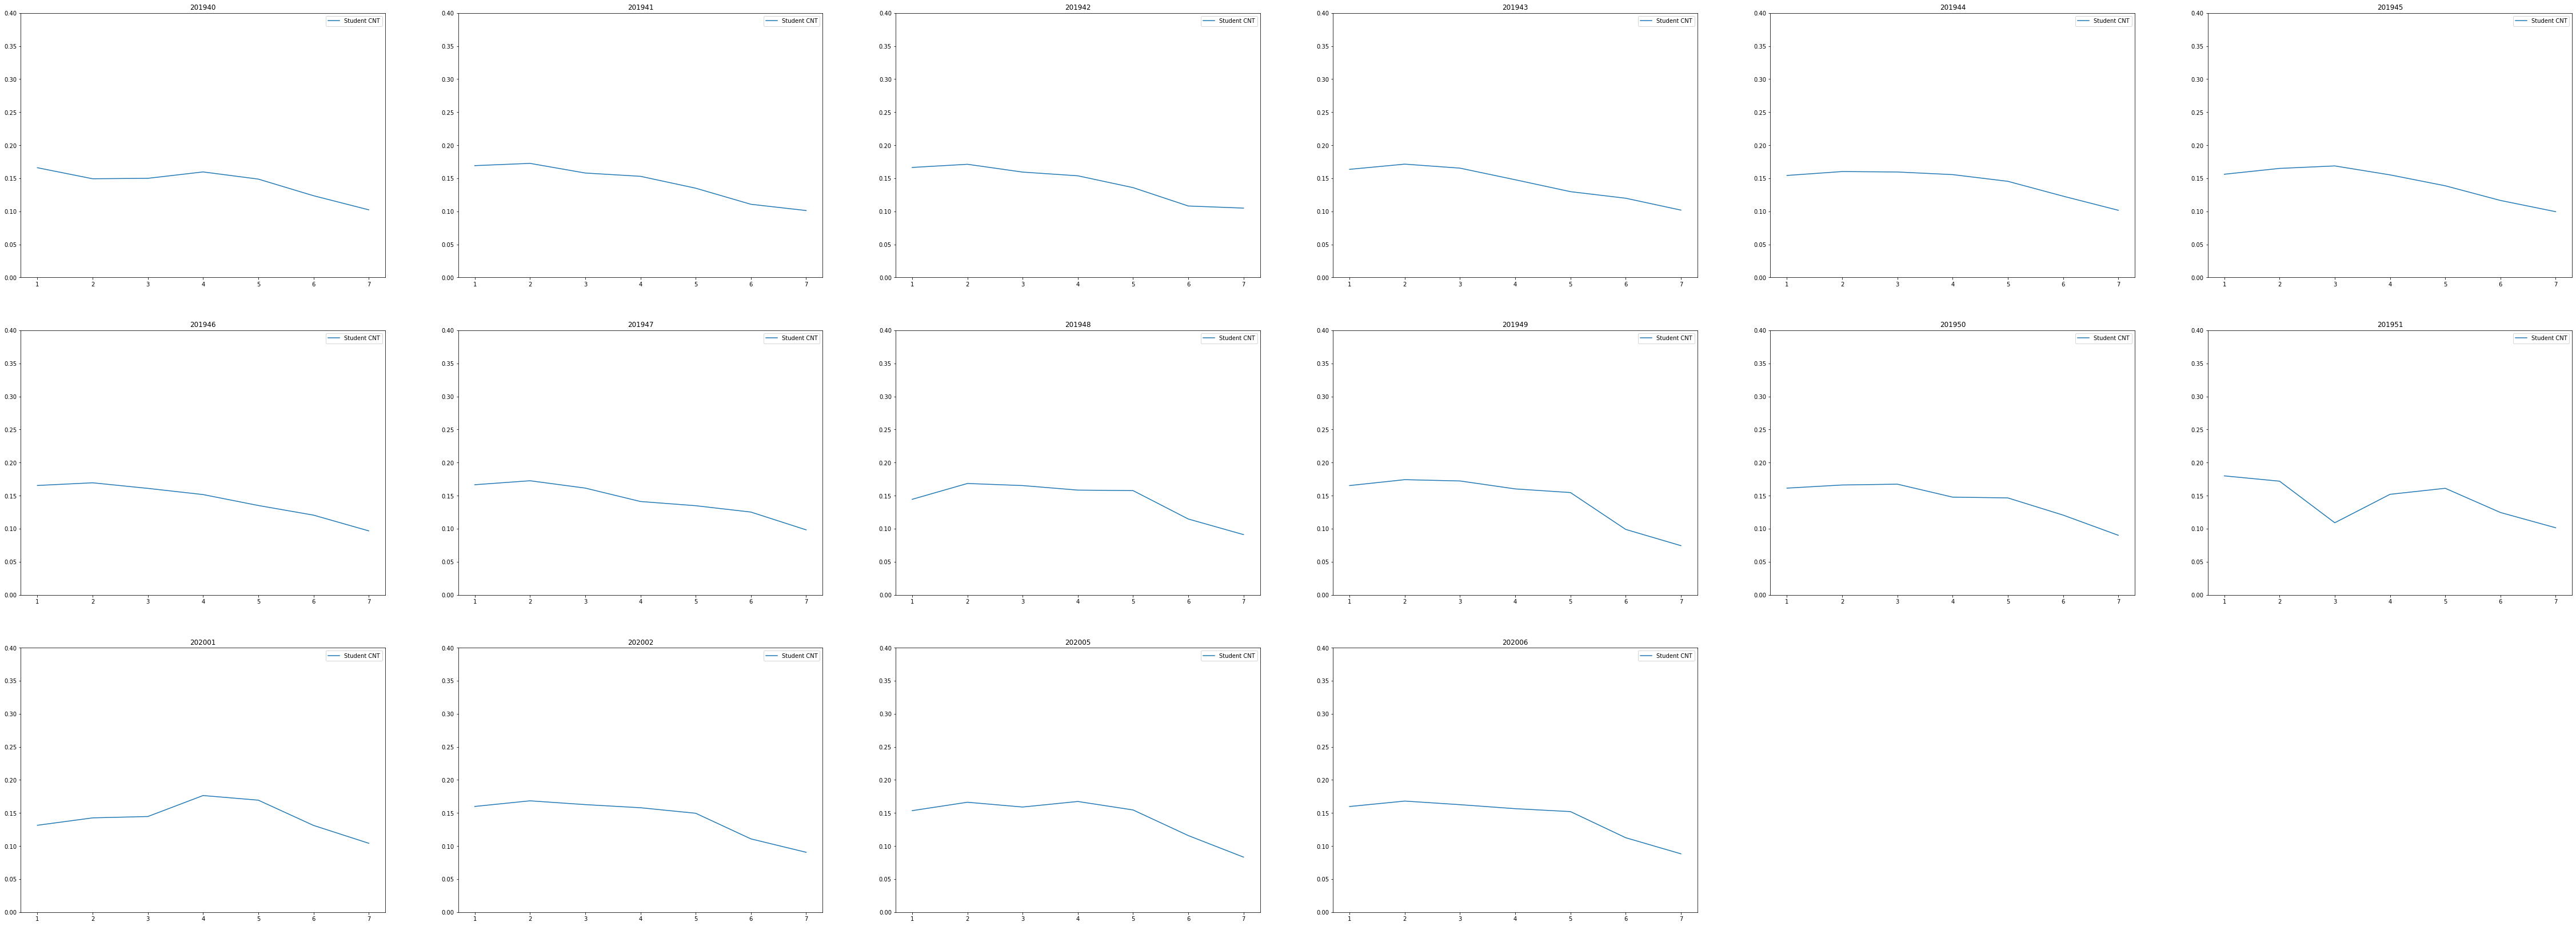

In [194]:
fig = plt.figure(1,figsize=(80, 80))
fig_index = 0
last = 20
for weekyear, week_data in dfps.iloc[-last:].iterrows():
    if week_data.isna().sum() > 0:
        continue
    fig_index += 1
    ax = fig.add_subplot(8,6,fig_index)
    ax.plot(week_data.index, week_data.values, label='Student CNT')
    ax.set_title(weekyear)
    ax.set_ylim((0,0.4))
    ax.legend()
    if fig_index > 47:
        break
plt.show()

In [196]:
dfps.iloc[-last:].mean()

weekday
1    0.198016
2    0.203188
3    0.161372
4    0.163734
5    0.157271
6    0.124988
7    0.102542
dtype: float64

In [198]:
dfps.iloc[-last:].mean().sum()

1.111111111111111

In [235]:
historical_data_without_afternoon = historical_data.loc[~historical_data.time_index.isin([7,8,9,10,11])]
week_dfps= historical_data_without_afternoon.pivot(index = 'date', columns = 'time_index', values = 'cnt')

In [236]:
week_dfps = week_dfps.apply(midu, axis=1)

In [239]:
week_dfps

time_index,0,1,2,3,4,5,6,12,13,14,15,16
date,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.203152,0.272428,0.295462,0.228957
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223913,0.285632,0.292378,0.198077
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.238079,0.279098,0.287301,0.195522
2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229266,0.286772,0.289239,0.194724
2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.208286,0.251969,0.301650,0.238095
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-12,0.030411,0.075160,0.087780,0.087239,0.074832,0.059703,0.037011,0.040908,0.106999,0.135558,0.138491,0.125909
2020-02-13,0.031883,0.073185,0.088571,0.084625,0.078598,0.061466,0.038526,0.040469,0.103323,0.135940,0.137665,0.125749
2020-02-14,0.032725,0.080769,0.091113,0.087453,0.077864,0.063023,0.036286,0.038813,0.103666,0.130622,0.133169,0.124495


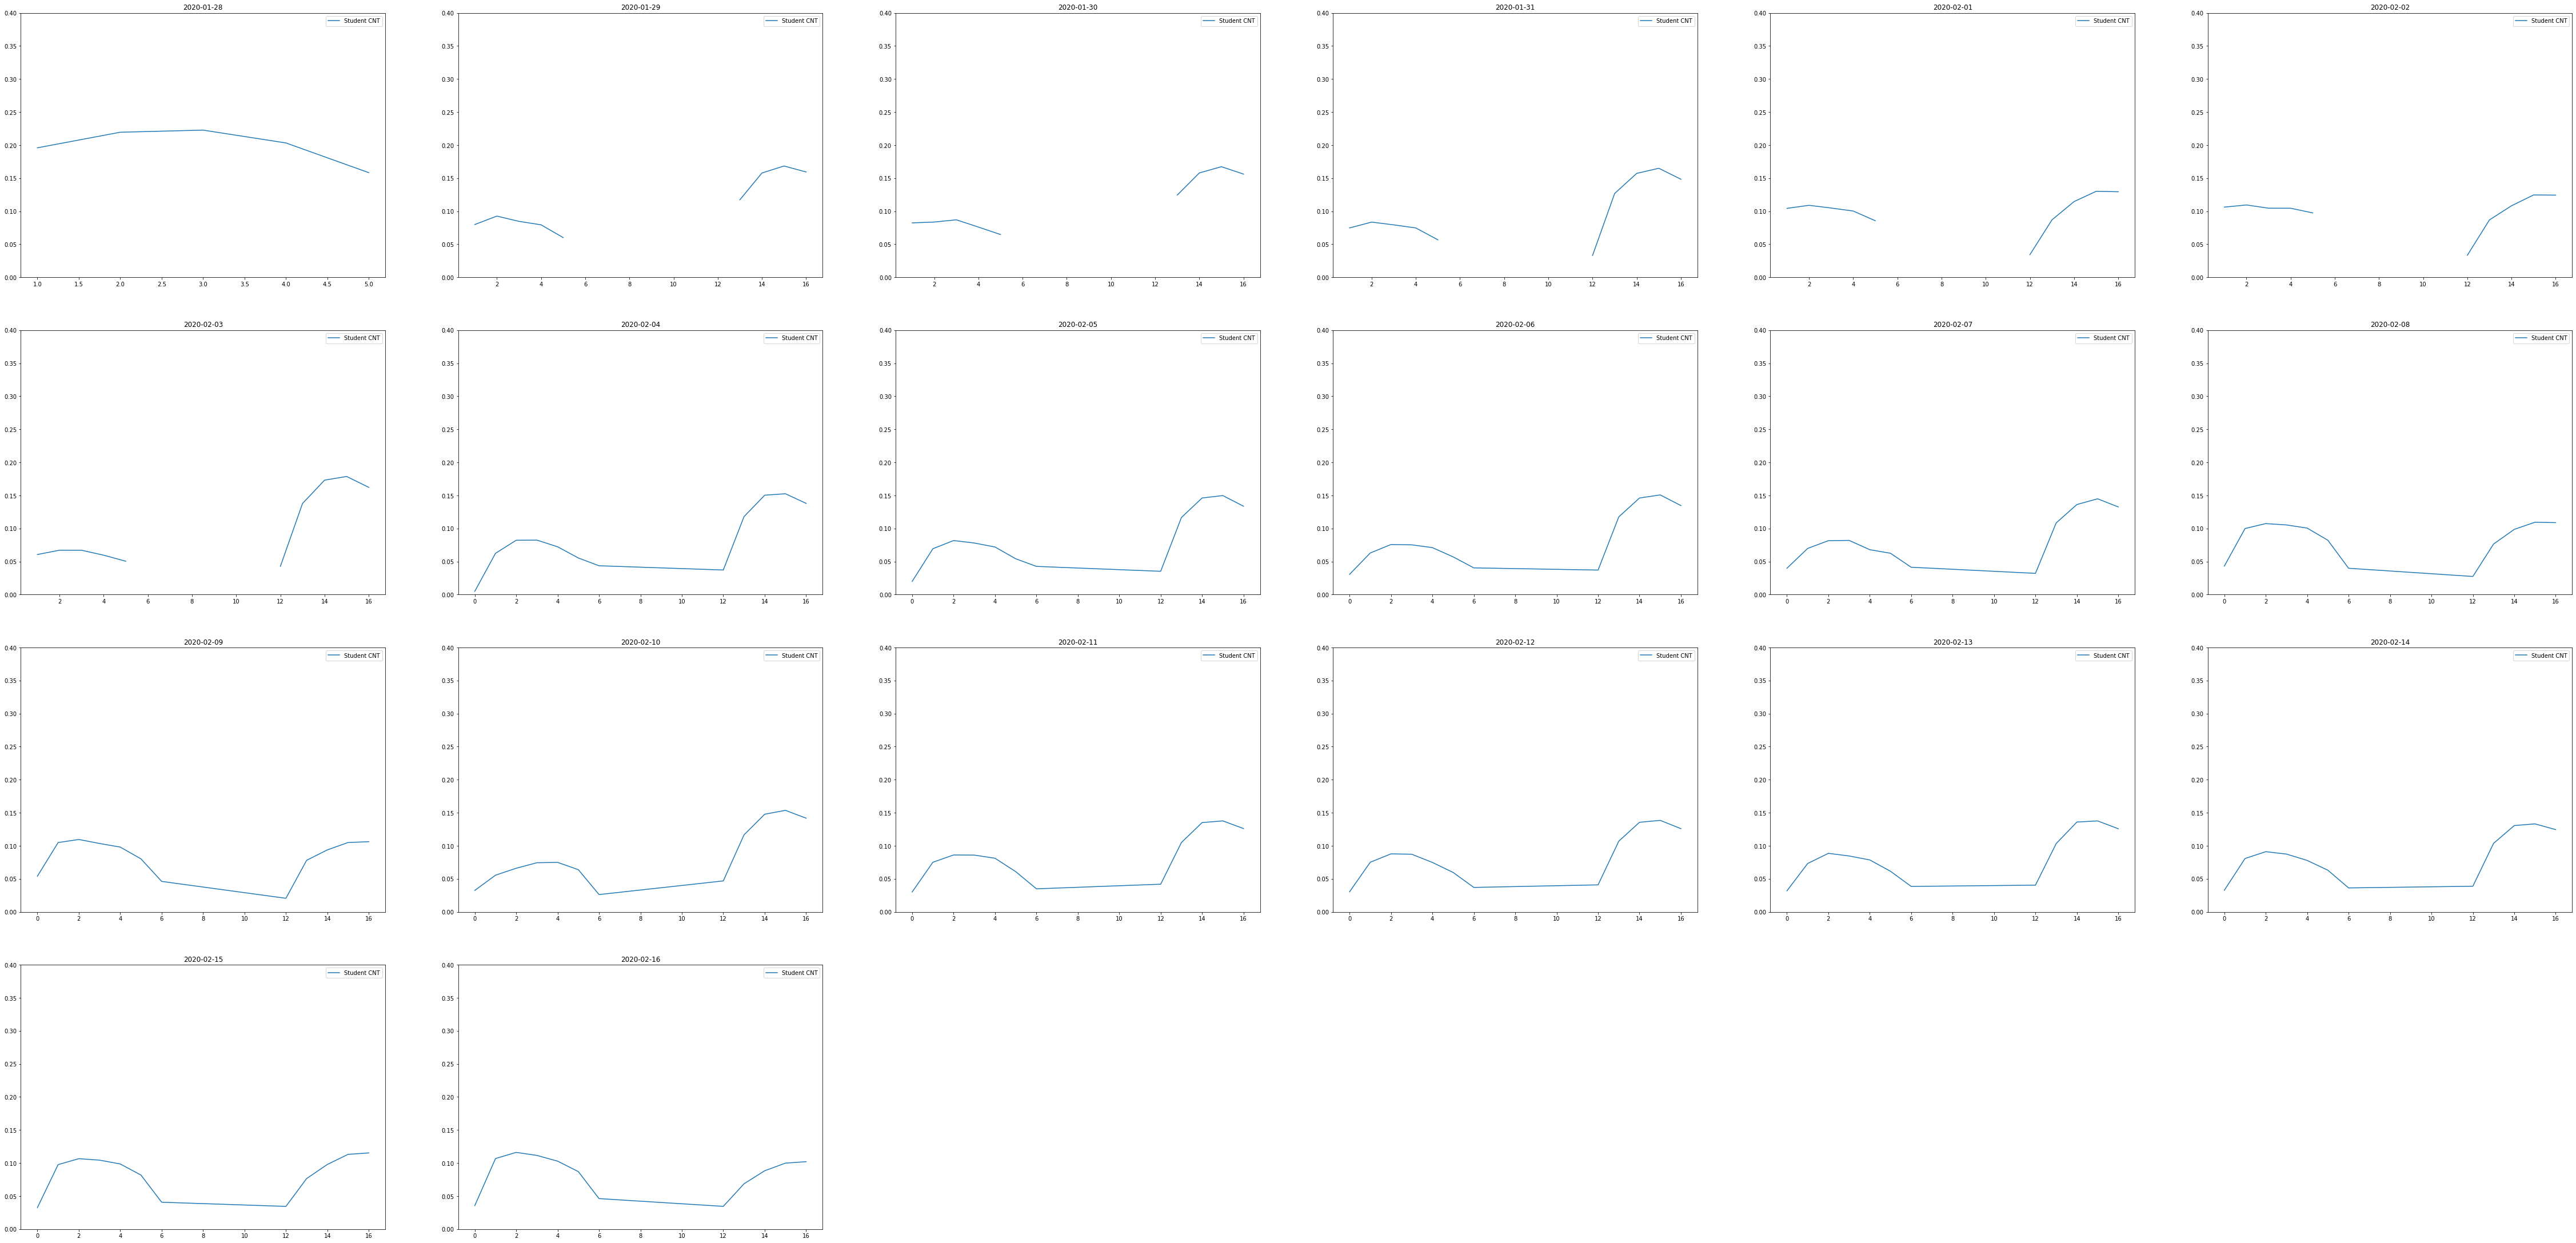

In [238]:
fig = plt.figure(1,figsize=(80, 80))
fig_index = 0
last = 20
for weekyear, week_data in week_dfps.iloc[-last:].iterrows():
    if week_data.isna().sum() > 70:
        continue
    fig_index += 1
    ax = fig.add_subplot(8,6,fig_index)
    ax.plot(week_data.index, week_data.values, label='Student CNT')
    ax.set_title(weekyear)
    ax.set_ylim((0,0.4))
    ax.legend()
    if fig_index > 47:
        break
plt.show()

In [243]:
s week_dfps.mean()

time_index
0     0.032203
1     0.089273
2     0.095060
3     0.092520
4     0.080310
5     0.065064
6     0.039556
12    0.035971
13    0.163213
14    0.211778
15    0.237922
16    0.204713
dtype: float64

In [127]:
pd.set_option('display.max_rows', 500)

In [ ]:
def sss(field, pre='norm'):
    a = historical_data_cnt[field]
    a = a.loc[~a.isna()]
    s = a / historical_data_cnt.loc[a.index, 'students']
    if pre == 'std':
        output = standardization(s)
    else:
        output = normalization(s)
    output.plot(figsize=(80,14))